### Importing Packages

#### Let us import standard libraries in python

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

## Step 1: 
### Reading and understanding the data from the source

In [2]:
df_bike = pd.read_csv("./day.csv")

#### Lets observe the data types of the columns and missing values

##### No Missing values present in the data

In [3]:
df_bike.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


# Data cleaning

## Removing unwanted columns
- Let us identify the columns that are redundant and where linear regression cannot be performed


In [4]:
def dropColumns(df,listCols):
    df = df.drop(listCols,axis=1)
    return df


In [5]:
df_bike = dropColumns(df_bike,["instant", "dteday", "casual","registered"])

# Step 2 - `Visualization of Data`



## Lets identify the numeric columns columns
- Temp
- atemp
- Hum
- windspeed

Let us visulize the data using pairplot in seaborn


#### Remaining columns are categorical columns

<Figure size 1152x648 with 0 Axes>

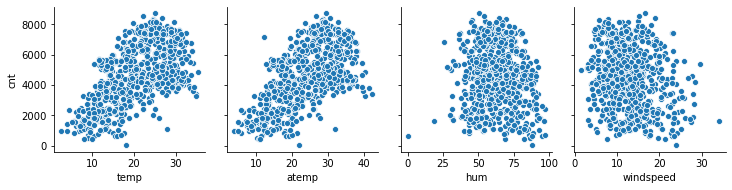

In [6]:
plt.figure(figsize=(16,9))
sns.pairplot(data=df_bike,x_vars= ['temp','atemp','hum','windspeed'],y_vars = 'cnt')

- We have a scatter plots of various variables in the top
- `Temp` and `Atemp` seem to be highly corelated. This will result in multi colinearity 
- We will only use <b>temp</b> column for builidng the model 
- 

In [7]:
df_bike = df_bike.drop(columns = 'atemp',axis=1)

In [8]:
df_bike.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
0,1,0,1,0,6,0,2,14.110847,80.5833,10.749882,985
1,1,0,1,0,0,0,2,14.902598,69.6087,16.652113,801
2,1,0,1,0,1,1,1,8.050924,43.7273,16.636703,1349
3,1,0,1,0,2,1,1,8.200000,59.0435,10.739832,1562
4,1,0,1,0,3,1,1,9.305237,43.6957,12.522300,1600


In [9]:
def format_columns(df,colName,array):
    df[colName] = df[colName].apply(lambda a: array[a])

### Lets form the categorical variables
- `Days`, `Months` , `Seasons` , ` weather` are the categorical variables where we have to create `n-1` dummy variables 
- Other columns are binary so no need of creating dummy variables

In [10]:
days = ["Sun","Mon",'Tue',"Wed","Thu","Fri","Sat"]
months = ["Jan",'Feb',"March",'Apr',"May","Jun","Jul","Aug",'Sep','Oct','Nov','Dec']
seasons = ['Spring','Summer','Fall','Winter'] ## As there are 4 seasons
weather = ['Clear','Mist','Light Rain']

- Days have base of zero while other columns have the base as one
- let use make the base index as zero and then introduce categories

In [11]:
### making the index zero

df_bike.loc[:,['mnth','season','weathersit']] = df_bike.loc[:,['mnth','season','weathersit']].apply(lambda x : x-1) 

### Formating them
format_columns(df_bike,'weekday',days)
format_columns(df_bike,'mnth',months)
format_columns(df_bike,'season',seasons)
format_columns(df_bike,'weathersit',weather)


Lets examine top 5 rows

In [12]:
df_bike.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
0,Spring,0,Jan,0,Sat,0,Mist,14.110847,80.5833,10.749882,985
1,Spring,0,Jan,0,Sun,0,Mist,14.902598,69.6087,16.652113,801
2,Spring,0,Jan,0,Mon,1,Clear,8.050924,43.7273,16.636703,1349
3,Spring,0,Jan,0,Tue,1,Clear,8.200000,59.0435,10.739832,1562
4,Spring,0,Jan,0,Wed,1,Clear,9.305237,43.6957,12.522300,1600


## Lets create dummy variables for categorical columns



 As we need only `n-1` dummy variables we will drop the first column from dummy variable 

In [13]:
## categorical columns
cat_cols= ['weekday','mnth','season','weathersit']
## logic to create dummy variables
df_weekday = pd.get_dummies(df_bike['weekday'],drop_first=True)
df_mnth = pd.get_dummies(df_bike['mnth'],drop_first=True)
df_season = pd.get_dummies(df_bike['season'],drop_first=True)
df_weathersit = pd.get_dummies(df_bike['weathersit'],drop_first=True)

### Here the first columns which are dropped are

   - weekday   `Friday` all column values will be 0 for `Fri`
   - Mnth      `April` all column values 0 for `April`
   - Season    `Fall`  all column values are0 for `Fall` 
   - weather   `Clear` all values will be 0 for `Clear`

### Concat the dataframe to single dataframe


In [14]:
df_bike = pd.concat([df_bike,df_weekday,df_mnth,df_season,df_weathersit],axis=1)

# Visualization part 2:

## The variables here are catgorical in nature

We will be using boxplot to visualize data

we will create subplots for each categorical columns

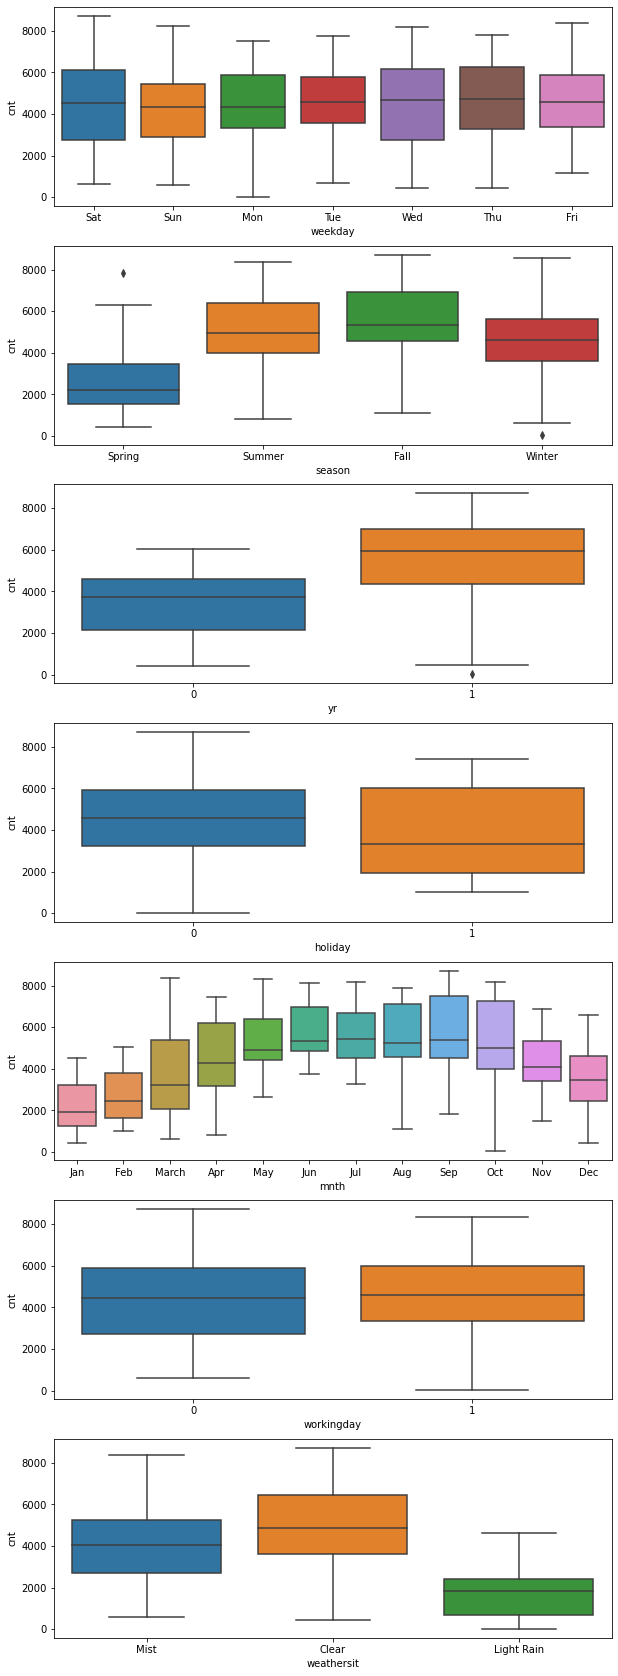

In [15]:
# we will create subplots
plt.subplots(7,1,figsize=(10,30))

plt.subplot(7,1,1)
sns.boxplot(data=df_bike,x='weekday',y='cnt')

plt.subplot(7,1,2)
sns.boxplot(data=df_bike,x='season',y='cnt')

plt.subplot(7,1,3)
sns.boxplot(data=df_bike,x='yr',y='cnt')

plt.subplot(7,1,4)
sns.boxplot(data=df_bike,x='holiday',y='cnt')

plt.subplot(7,1,5)
sns.boxplot(data=df_bike,x='mnth',y='cnt')

plt.subplot(7,1,6)
sns.boxplot(data=df_bike,x='workingday',y='cnt')

plt.subplot(7,1,7)
sns.boxplot(data=df_bike,x='weathersit',y='cnt')


# Step 3 - Building the model

### Splitting the data to train and test dataset
- 75% of the data is train set and the remainig 25% data is test set

In [16]:
df_bike_train,df_bike_test = train_test_split(df_bike,train_size = 0.75,random_state=1)


df_bike_train = df_bike_train.drop(columns=['weekday','mnth','season','weathersit'],axis=1)
df_bike_test = df_bike_test.drop(columns=['weekday','mnth','season','weathersit'],axis=1)




## Data scaling

### Scale the data using min maxscaler

In [17]:
scaler = MinMaxScaler()
col = ['temp','hum','windspeed','cnt']
df_bike_train[col] = scaler.fit_transform(df_bike_train[col])
#df_bike_train_y = scaler.fit_transform(df_bike_train_y)

## Creating the linear regression object with sklearn

- we will separate x and y from the train set
- we will instanciate a starting model `lm` for regression analysis

In [18]:
###let us split inputs and outputs in linear regression
df_bike_train_y = df_bike_train.pop('cnt')
df_bike_train_x = df_bike_train

lm = LinearRegression()
lm.fit(df_bike_train_x,df_bike_train_y )

LinearRegression()

### Let us use this linear regression model for feature selection
1. We will use mixed approach for modelling
2. First we will choose 25 variables using RFE method if sklearn
3. Once get those 25 varaibles we will do backward approcach by removing variables one by one

In [19]:
rfe = RFE(lm, 25)     
rfe = rfe.fit(df_bike_train_x,df_bike_train_y)
list(zip(df_bike_train_x,rfe.support_,rfe.ranking_))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_features_to_select=25 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('Mon', True, 1),
 ('Sat', True, 1),
 ('Sun', True, 1),
 ('Thu', False, 2),
 ('Tue', True, 1),
 ('Wed', False, 3),
 ('Aug', True, 1),
 ('Dec', True, 1),
 ('Feb', True, 1),
 ('Jan', True, 1),
 ('Jul', True, 1),
 ('Jun', False, 4),
 ('March', True, 1),
 ('May', True, 1),
 ('Nov', True, 1),
 ('Oct', True, 1),
 ('Sep', True, 1),
 ('Spring', True, 1),
 ('Summer', True, 1),
 ('Winter', True, 1),
 ('Light Rain', True, 1),
 ('Mist', True, 1)]

## Filtering train set

We will only include the columns in the training set which are rfe supported

In [20]:
#colToDrop = ['Tue','Wed','Thu','Feb']
#df_bike_train_x = df_bike_train_x.drop(columns = colToDrop,axis = 1)
df_bike_train_x = df_bike_train_x[df_bike_train_x.columns[rfe.support_]]

## Test the model with statsmodel and check the p values with summary statistics
1. R(sqared) has to be high and the value of p should be very low
2. Lets observe the summary statistics of the model

In [21]:
## Adding constant
X_train_sm = sm.add_constant(df_bike_train_x)
y_train = df_bike_train_y
## lets fit the model
lm_1 = sm.OLS(y_train,X_train_sm).fit()
lm_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     113.4
Date:                Wed, 30 Dec 2020   Prob (F-statistic):          1.53e-189
Time:                        22:16:49   Log-Likelihood:                 556.59
No. Observations:                 547   AIC:                            -1063.
Df Residuals:                     522   BIC:                            -955.6
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2610      0.034      7.743      0.000       0.195       0.327
yr             0.2339      0.008     29.743      0.000       0.218       0.249
holiday        0.0200      0.022      0.920      0.358      -0.023       0.063
workingday     0.0870      0.011      8.157      0.000       0.066       0.108
temp           0.4301      0.040     10.783      0.000       0.352       0.508
hum           -0.1589      0.032     -4.891      0.000      -0.223      -0.095
windspeed     -0.1930      0.026     -7.473      0.000      -0.244      -0.142
Mon           -0.0154      0.012     -1.278      0.202      -0.039       0.008
Sat            0.1115      0.013      8.703      0.000       0.086       0.137
Sun            0.0425      0.012      3.427      0.001       0.018       0.067
Tue           -0.0145      0.012     -1.213      0.226      -0.038       0.009
Aug           -0.0058      0.025     -0.234      0.815      -0.055       0.043
Dec           -0.0372      0.033     -1.133      0.258      -0.102       0.027
Feb           -0.0171      0.033     -0.521      0.602      -0.082       0.047
Jan           -0.0394      0.034     -1.160      0.246      -0.106       0.027
Jul           -0.0413      0.025     -1.656      0.098      -0.090       0.008
March          0.0430      0.024      1.785      0.075      -0.004       0.090
May            0.0327      0.017      1.977      0.049       0.000       0.065
Nov           -0.0331      0.035     -0.953      0.341      -0.101       0.035
Oct            0.0341      0.033      1.033      0.302      -0.031       0.099
Sep            0.0778      0.025      3.097      0.002       0.028       0.127
Spring        -0.0910      0.030     -3.066      0.002      -0.149      -0.033
Summer         0.0160      0.024      0.663      0.507      -0.031       0.063
Winter         0.0652      0.026      2.519      0.012       0.014       0.116
Light Rain    -0.2204      0.027     -8.058      0.000      -0.274      -0.167
Mist          -0.0340      0.011     -3.181      0.002      -0.055      -0.013
==============================================================================
Omnibus:                       99.469   Durbin-Watson:                   1.889
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              248.234
Skew:                          -0.925   Prob(JB):                     1.25e-54
Kurtosis:                       5.733   Cond. No.                     5.52e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.38e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### Lets  observe the variance inflation factor(vif) of the model

In [22]:
vif = pd.DataFrame()
X = X_train_sm
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,Features,VIF
9,Sun,inf
2,holiday,inf
3,workingday,inf
8,Sat,inf
21,Spring,10.42
23,Winter,8.50
22,Summer,7.66
18,Nov,6.96
14,Jan,5.81
19,Oct,5.62


### `Saturday`, `Holiday` , `working day` and `Sunday` are having infinite vif we will drop them

In [23]:
X_train_sm = X_train_sm.drop(['holiday','workingday','Sat','Sun'],axis =1)
lm_2 = sm.OLS(y_train,X_train_sm).fit()
lm_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     121.3
Date:                Wed, 30 Dec 2020   Prob (F-statistic):          7.22e-186
Time:                        22:16:50   Log-Likelihood:                 540.08
No. Observations:                 547   AIC:                            -1036.
Df Residuals:                     525   BIC:                            -941.5
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3490      0.043      8.211      0.000       0.266       0.433
yr             0.2324      0.008     28.788      0.000       0.217       0.248
temp           0.4293      0.041     10.549      0.000       0.349       0.509
hum           -0.1679      0.033     -5.045      0.000      -0.233      -0.103
windspeed     -0.1927      0.026     -7.275      0.000      -0.245      -0.141
Mon           -0.0186      0.011     -1.653      0.099      -0.041       0.004
Tue           -0.0085      0.012     -0.724      0.469      -0.031       0.015
Aug           -0.0058      0.026     -0.226      0.821      -0.056       0.045
Dec           -0.0386      0.034     -1.150      0.251      -0.104       0.027
Feb           -0.0127      0.034     -0.379      0.705      -0.079       0.053
Jan           -0.0390      0.035     -1.123      0.262      -0.107       0.029
Jul           -0.0446      0.026     -1.746      0.081      -0.095       0.006
March          0.0466      0.025      1.892      0.059      -0.002       0.095
May            0.0352      0.017      2.072      0.039       0.002       0.069
Nov           -0.0379      0.035     -1.072      0.284      -0.107       0.032
Oct            0.0309      0.034      0.914      0.361      -0.035       0.097
Sep            0.0746      0.026      2.896      0.004       0.024       0.125
Spring        -0.0973      0.030     -3.196      0.001      -0.157      -0.037
Summer         0.0143      0.025      0.578      0.563      -0.034       0.063
Winter         0.0636      0.027      2.396      0.017       0.011       0.116
Light Rain    -0.2068      0.028     -7.394      0.000      -0.262      -0.152
Mist          -0.0305      0.011     -2.788      0.005      -0.052      -0.009
==============================================================================
Omnibus:                       98.301   Durbin-Watson:                   1.934
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              233.744
Skew:                          -0.932   Prob(JB):                     1.75e-51
Kurtosis:                       5.604   Cond. No.                         32.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Let us examine the vif

In [24]:
vif = pd.DataFrame()
X = X_train_sm
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,116.72
17,Spring,10.38
19,Winter,8.45
18,Summer,7.65
14,Nov,6.82
10,Jan,5.75
15,Oct,5.56
2,temp,5.48
9,Feb,5.03
8,Dec,4.92


 ## Lets drop the columns based on p values
 
 - Dropping July Column as It has high p value
 - Fit the model
 - Observe the summary statistics

## We will drop the month `Aug`  as it has high p value

In [25]:
## Dropping Aug Column as It has high p value
X_train_sm = X_train_sm.drop(['Aug'],axis =1)

## lets fit the model
lm_2 = sm.OLS(y_train,X_train_sm).fit()
lm_2.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     127.5
Date:                Wed, 30 Dec 2020   Prob (F-statistic):          6.47e-187
Time:                        22:16:51   Log-Likelihood:                 540.05
No. Observations:                 547   AIC:                            -1038.
Df Residuals:                     526   BIC:                            -947.7
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3449      0.038      8.982      0.000       0.269       0.420
yr             0.2324      0.008     28.818      0.000       0.217       0.248
temp           0.4295      0.041     10.566      0.000       0.350       0.509
hum           -0.1685      0.033     -5.080      0.000      -0.234      -0.103
windspeed     -0.1927      0.026     -7.281      0.000      -0.245      -0.141
Mon           -0.0186      0.011     -1.653      0.099      -0.041       0.004
Tue           -0.0084      0.012     -0.719      0.472      -0.031       0.015
Dec           -0.0361      0.032     -1.140      0.255      -0.098       0.026
Feb           -0.0112      0.033     -0.342      0.733      -0.076       0.053
Jan           -0.0374      0.034     -1.101      0.271      -0.104       0.029
Jul           -0.0404      0.018     -2.294      0.022      -0.075      -0.006
March          0.0476      0.024      1.965      0.050    5.94e-06       0.095
May            0.0354      0.017      2.088      0.037       0.002       0.069
Nov           -0.0350      0.033     -1.063      0.288      -0.100       0.030
Oct            0.0338      0.031      1.082      0.280      -0.028       0.095
Sep            0.0785      0.019      4.147      0.000       0.041       0.116
Spring        -0.0945      0.028     -3.391      0.001      -0.149      -0.040
Summer         0.0184      0.017      1.080      0.281      -0.015       0.052
Winter         0.0650      0.026      2.518      0.012       0.014       0.116
Light Rain    -0.2066      0.028     -7.397      0.000      -0.262      -0.152
Mist          -0.0305      0.011     -2.787      0.006      -0.052      -0.009
==============================================================================
Omnibus:                       98.028   Durbin-Watson:                   1.933
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              232.918
Skew:                          -0.930   Prob(JB):                     2.65e-51
Kurtosis:                       5.600   Cond. No.                         29.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Let us examine the vif

In [26]:
vif = pd.DataFrame()
X = X_train_sm
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,95.43
16,Spring,8.72
18,Winter,8.00
13,Nov,5.92
9,Jan,5.53
2,temp,5.47
8,Feb,4.83
14,Oct,4.76
7,Dec,4.40
17,Summer,3.62


### Dropping Feb Column as It has high p value

In [27]:
## Dropping Feb Column as It has high p value
X_train_sm = X_train_sm.drop(['Feb'],axis =1)

## lets fit the model
lm_3 = sm.OLS(y_train,X_train_sm).fit()
lm_3.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     134.5
Date:                Wed, 30 Dec 2020   Prob (F-statistic):          5.83e-188
Time:                        22:16:53   Log-Likelihood:                 539.99
No. Observations:                 547   AIC:                            -1040.
Df Residuals:                     527   BIC:                            -953.9
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3401      0.036      9.533      0.000       0.270       0.410
yr             0.2322      0.008     28.895      0.000       0.216       0.248
temp           0.4352      0.037     11.733      0.000       0.362       0.508
hum           -0.1690      0.033     -5.106      0.000      -0.234      -0.104
windspeed     -0.1924      0.026     -7.280      0.000      -0.244      -0.141
Mon           -0.0187      0.011     -1.670      0.095      -0.041       0.003
Tue           -0.0087      0.012     -0.746      0.456      -0.032       0.014
Dec           -0.0291      0.024     -1.209      0.227      -0.076       0.018
Jan           -0.0279      0.020     -1.427      0.154      -0.066       0.011
Jul           -0.0402      0.018     -2.286      0.023      -0.075      -0.006
March          0.0534      0.017      3.084      0.002       0.019       0.087
May            0.0359      0.017      2.127      0.034       0.003       0.069
Nov           -0.0292      0.028     -1.037      0.300      -0.084       0.026
Oct            0.0388      0.028      1.410      0.159      -0.015       0.093
Sep            0.0805      0.018      4.458      0.000       0.045       0.116
Spring        -0.1003      0.022     -4.504      0.000      -0.144      -0.057
Summer         0.0192      0.017      1.141      0.254      -0.014       0.052
Winter         0.0621      0.024      2.549      0.011       0.014       0.110
Light Rain    -0.2066      0.028     -7.403      0.000      -0.261      -0.152
Mist          -0.0303      0.011     -2.775      0.006      -0.052      -0.009
==============================================================================
Omnibus:                       97.094   Durbin-Watson:                   1.936
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              229.083
Skew:                          -0.924   Prob(JB):                     1.80e-50
Kurtosis:                       5.576   Cond. No.                         22.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Observing the vif values

In [28]:
vif = pd.DataFrame()
X = X_train_sm
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,82.50
17,Winter,7.15
15,Spring,5.57
2,temp,4.56
12,Nov,4.33
13,Oct,3.71
16,Summer,3.55
7,Dec,2.54
3,hum,2.27
8,Jan,1.84


## Dropping columns with high p:

- Tue column has large p value
- dropping `Tue` column

In [29]:
## Tue column has large p value
## dropping Tue
X_train_sm = X_train_sm.drop(['Tue'],axis =1)
lm_4 = sm.OLS(y_train,X_train_sm).fit()
lm_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     142.0
Date:                Wed, 30 Dec 2020   Prob (F-statistic):          6.36e-189
Time:                        22:16:54   Log-Likelihood:                 539.70
No. Observations:                 547   AIC:                            -1041.
Df Residuals:                     528   BIC:                            -959.6
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3395      0.036      9.524      0.000       0.270       0.410
yr             0.2323      0.008     28.920      0.000       0.216       0.248
temp           0.4346      0.037     11.725      0.000       0.362       0.507
hum           -0.1690      0.033     -5.107      0.000      -0.234      -0.104
windspeed     -0.1934      0.026     -7.331      0.000      -0.245      -0.142
Mon           -0.0173      0.011     -1.565      0.118      -0.039       0.004
Dec           -0.0289      0.024     -1.201      0.230      -0.076       0.018
Jan           -0.0281      0.020     -1.434      0.152      -0.067       0.010
Jul           -0.0404      0.018     -2.294      0.022      -0.075      -0.006
March          0.0535      0.017      3.090      0.002       0.019       0.088
May            0.0355      0.017      2.103      0.036       0.002       0.069
Nov           -0.0290      0.028     -1.032      0.302      -0.084       0.026
Oct            0.0388      0.028      1.411      0.159      -0.015       0.093
Sep            0.0812      0.018      4.506      0.000       0.046       0.117
Spring        -0.1003      0.022     -4.509      0.000      -0.144      -0.057
Summer         0.0192      0.017      1.140      0.255      -0.014       0.052
Winter         0.0617      0.024      2.536      0.012       0.014       0.110
Light Rain    -0.2061      0.028     -7.390      0.000      -0.261      -0.151
Mist          -0.0309      0.011     -2.840      0.005      -0.052      -0.010
==============================================================================
Omnibus:                       97.265   Durbin-Watson:                   1.938
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              232.214
Skew:                          -0.922   Prob(JB):                     3.76e-51
Kurtosis:                       5.606   Cond. No.                         22.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Observing vif values

In [30]:
vif = pd.DataFrame()
X = X_train_sm
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,82.46
16,Winter,7.15
14,Spring,5.57
2,temp,4.56
11,Nov,4.33
12,Oct,3.71
15,Summer,3.55
6,Dec,2.54
3,hum,2.27
7,Jan,1.84


## Dropping columns with high p:

- Tue column has large p value
- dropping `Nov` column

In [31]:
### Dropping Nov column
X_train_sm = X_train_sm.drop(['Nov'],axis =1)
lm_5 = sm.OLS(y_train,X_train_sm).fit()
lm_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     150.3
Date:                Wed, 30 Dec 2020   Prob (F-statistic):          8.66e-190
Time:                        22:16:55   Log-Likelihood:                 539.15
No. Observations:                 547   AIC:                            -1042.
Df Residuals:                     529   BIC:                            -964.8
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3290      0.034      9.630      0.000       0.262       0.396
yr             0.2320      0.008     28.901      0.000       0.216       0.248
temp           0.4457      0.035     12.560      0.000       0.376       0.515
hum           -0.1710      0.033     -5.178      0.000      -0.236      -0.106
windspeed     -0.1935      0.026     -7.335      0.000      -0.245      -0.142
Mon           -0.0175      0.011     -1.586      0.113      -0.039       0.004
Dec           -0.0118      0.017     -0.678      0.498      -0.046       0.022
Jan           -0.0234      0.019     -1.227      0.220      -0.061       0.014
Jul           -0.0385      0.018     -2.199      0.028      -0.073      -0.004
March          0.0558      0.017      3.250      0.001       0.022       0.090
May            0.0349      0.017      2.073      0.039       0.002       0.068
Oct            0.0601      0.018      3.313      0.001       0.024       0.096
Sep            0.0890      0.016      5.452      0.000       0.057       0.121
Spring        -0.0963      0.022     -4.396      0.000      -0.139      -0.053
Summer         0.0237      0.016      1.460      0.145      -0.008       0.056
Winter         0.0461      0.019      2.420      0.016       0.009       0.083
Light Rain    -0.2067      0.028     -7.410      0.000      -0.261      -0.152
Mist          -0.0299      0.011     -2.757      0.006      -0.051      -0.009
==============================================================================
Omnibus:                       98.767   Durbin-Watson:                   1.936
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              235.364
Skew:                          -0.936   Prob(JB):                     7.79e-52
Kurtosis:                       5.612   Cond. No.                         20.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [32]:
vif = pd.DataFrame()
X = X_train_sm
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,75.74
13,Spring,5.40
15,Winter,4.37
2,temp,4.18
14,Summer,3.31
3,hum,2.26
7,Jan,1.74
17,Mist,1.68
8,Jul,1.62
11,Oct,1.61


## Dropping columns with high p:

- Tue column has large p value
- dropping `Dec` column

In [33]:
## Dropping Dec as p value is high dor Dec
X_train_sm = X_train_sm.drop(['Dec'],axis =1)
lm_6 = sm.OLS(y_train,X_train_sm).fit()
lm_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     159.8
Date:                Wed, 30 Dec 2020   Prob (F-statistic):          8.47e-191
Time:                        22:16:55   Log-Likelihood:                 538.91
No. Observations:                 547   AIC:                            -1044.
Df Residuals:                     530   BIC:                            -970.6
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3261      0.034      9.626      0.000       0.260       0.393
yr             0.2318      0.008     28.911      0.000       0.216       0.248
temp           0.4496      0.035     12.851      0.000       0.381       0.518
hum           -0.1728      0.033     -5.248      0.000      -0.237      -0.108
windspeed     -0.1924      0.026     -7.310      0.000      -0.244      -0.141
Mon           -0.0176      0.011     -1.590      0.112      -0.039       0.004
Jan           -0.0204      0.019     -1.101      0.271      -0.057       0.016
Jul           -0.0384      0.017     -2.193      0.029      -0.073      -0.004
March          0.0574      0.017      3.377      0.001       0.024       0.091
May            0.0351      0.017      2.083      0.038       0.002       0.068
Oct            0.0635      0.017      3.634      0.000       0.029       0.098
Sep            0.0905      0.016      5.596      0.000       0.059       0.122
Spring        -0.0968      0.022     -4.423      0.000      -0.140      -0.054
Summer         0.0246      0.016      1.516      0.130      -0.007       0.056
Winter         0.0443      0.019      2.351      0.019       0.007       0.081
Light Rain    -0.2064      0.028     -7.405      0.000      -0.261      -0.152
Mist          -0.0298      0.011     -2.750      0.006      -0.051      -0.008
==============================================================================
Omnibus:                       97.618   Durbin-Watson:                   1.937
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              228.765
Skew:                          -0.932   Prob(JB):                     2.11e-50
Kurtosis:                       5.562   Cond. No.                         20.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [34]:
vif = pd.DataFrame()
X = X_train_sm
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,74.54
12,Spring,5.39
14,Winter,4.29
2,temp,4.07
13,Summer,3.29
3,hum,2.25
16,Mist,1.68
6,Jan,1.65
7,Jul,1.62
9,May,1.53


## Dropping columns with high p:

- Tue column has large p value
- dropping `Jan` column

In [35]:
### Dropping Jan column with high p value
X_train_sm = X_train_sm.drop(['Jan'],axis =1)
lm_7 = sm.OLS(y_train,X_train_sm).fit()
lm_7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     170.3
Date:                Wed, 30 Dec 2020   Prob (F-statistic):          1.16e-191
Time:                        22:16:56   Log-Likelihood:                 538.29
No. Observations:                 547   AIC:                            -1045.
Df Residuals:                     531   BIC:                            -975.7
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3199      0.033      9.574      0.000       0.254       0.386
yr             0.2317      0.008     28.895      0.000       0.216       0.248
temp           0.4574      0.034     13.349      0.000       0.390       0.525
hum           -0.1735      0.033     -5.270      0.000      -0.238      -0.109
windspeed     -0.1906      0.026     -7.254      0.000      -0.242      -0.139
Mon           -0.0179      0.011     -1.619      0.106      -0.040       0.004
Jul           -0.0391      0.017     -2.234      0.026      -0.073      -0.005
March          0.0626      0.016      3.836      0.000       0.031       0.095
May            0.0355      0.017      2.105      0.036       0.002       0.069
Oct            0.0626      0.017      3.586      0.000       0.028       0.097
Sep            0.0906      0.016      5.601      0.000       0.059       0.122
Spring        -0.1017      0.021     -4.740      0.000      -0.144      -0.060
Summer         0.0251      0.016      1.548      0.122      -0.007       0.057
Winter         0.0472      0.019      2.527      0.012       0.010       0.084
Light Rain    -0.2057      0.028     -7.382      0.000      -0.260      -0.151
Mist          -0.0297      0.011     -2.748      0.006      -0.051      -0.008
==============================================================================
Omnibus:                       96.884   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              223.452
Skew:                          -0.931   Prob(JB):                     3.01e-49
Kurtosis:                       5.518   Cond. No.                         20.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
vif = pd.DataFrame()
X = X_train_sm
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,72.46
11,Spring,5.18
13,Winter,4.21
2,temp,3.90
12,Summer,3.29
3,hum,2.25
15,Mist,1.68
6,Jul,1.62
8,May,1.53
9,Oct,1.49


## Dropping columns with high p:

- Tue column has large p value
- dropping `Summer` column

In [37]:
X_train_sm = X_train_sm.drop(['Summer'],axis =1)
lm_8 = sm.OLS(y_train,X_train_sm).fit()
lm_8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     181.9
Date:                Wed, 30 Dec 2020   Prob (F-statistic):          2.78e-192
Time:                        22:16:57   Log-Likelihood:                 537.06
No. Observations:                 547   AIC:                            -1044.
Df Residuals:                     532   BIC:                            -979.5
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3461      0.029     12.006      0.000       0.289       0.403
yr             0.2321      0.008     28.917      0.000       0.216       0.248
temp           0.4365      0.032     13.843      0.000       0.375       0.498
hum           -0.1725      0.033     -5.236      0.000      -0.237      -0.108
windspeed     -0.1876      0.026     -7.150      0.000      -0.239      -0.136
Mon           -0.0178      0.011     -1.613      0.107      -0.040       0.004
Jul           -0.0484      0.016     -2.947      0.003      -0.081      -0.016
March          0.0673      0.016      4.188      0.000       0.036       0.099
May            0.0469      0.015      3.090      0.002       0.017       0.077
Oct            0.0639      0.017      3.661      0.000       0.030       0.098
Sep            0.0819      0.015      5.392      0.000       0.052       0.112
Spring        -0.1241      0.016     -7.852      0.000      -0.155      -0.093
Winter         0.0294      0.015      1.995      0.047       0.000       0.058
Light Rain    -0.2066      0.028     -7.407      0.000      -0.261      -0.152
Mist          -0.0301      0.011     -2.773      0.006      -0.051      -0.009
==============================================================================
Omnibus:                       98.150   Durbin-Watson:                   1.937
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              232.864
Skew:                          -0.932   Prob(JB):                     2.72e-51
Kurtosis:                       5.597   Cond. No.                         17.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
vif = pd.DataFrame()
X = X_train_sm
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,53.81
2,temp,3.30
11,Spring,2.80
12,Winter,2.61
3,hum,2.25
14,Mist,1.68
9,Oct,1.49
6,Jul,1.43
13,Light Rain,1.43
8,May,1.24


## Dropping columns with high p:

- Tue column has large p value
- dropping `Mon` column

In [39]:
X_train_sm = X_train_sm.drop(['Mon'],axis =1)
lm_9 = sm.OLS(y_train,X_train_sm).fit()
lm_9.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     195.1
Date:                Wed, 30 Dec 2020   Prob (F-statistic):          7.11e-193
Time:                        22:16:57   Log-Likelihood:                 535.72
No. Observations:                 547   AIC:                            -1043.
Df Residuals:                     533   BIC:                            -983.2
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3443      0.029     11.933      0.000       0.288       0.401
yr             0.2324      0.008     28.912      0.000       0.217       0.248
temp           0.4377      0.032     13.861      0.000       0.376       0.500
hum           -0.1747      0.033     -5.296      0.000      -0.239      -0.110
windspeed     -0.1892      0.026     -7.205      0.000      -0.241      -0.138
Jul           -0.0494      0.016     -3.007      0.003      -0.082      -0.017
March          0.0673      0.016      4.181      0.000       0.036       0.099
May            0.0471      0.015      3.100      0.002       0.017       0.077
Oct            0.0622      0.017      3.566      0.000       0.028       0.096
Sep            0.0818      0.015      5.373      0.000       0.052       0.112
Spring        -0.1240      0.016     -7.828      0.000      -0.155      -0.093
Winter         0.0303      0.015      2.054      0.040       0.001       0.059
Light Rain    -0.2050      0.028     -7.343      0.000      -0.260      -0.150
Mist          -0.0298      0.011     -2.743      0.006      -0.051      -0.008
==============================================================================
Omnibus:                       95.518   Durbin-Watson:                   1.938
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              225.727
Skew:                          -0.910   Prob(JB):                     9.64e-50
Kurtosis:                       5.568   Cond. No.                         17.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Now the p values for all the features are balanced which is less than 0.05 and acceptable


Now we will stop the feature elimination as p values are below the `0.05` threshold

In [40]:
vif = pd.DataFrame()
X = X_train_sm
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,53.72
2,temp,3.29
10,Spring,2.80
11,Winter,2.60
3,hum,2.24
13,Mist,1.68
8,Oct,1.48
12,Light Rain,1.43
5,Jul,1.42
7,May,1.24


## Scaling the test set

1. We will scale the test data with min max scaler
2. We will create `X-Test` and `y-test` data sets for test dataframe
3. Dirst we will observe the behaviour of the built model on train set
4. We will later observe the behaviour of the built model on test data set

In [41]:
col = ['temp','hum','windspeed','cnt']
df_bike_test[col] = scaler.transform(df_bike_test[col])
y_test = df_bike_test.pop('cnt')
X_test = df_bike_test

## Observing the distribution of the error terms of the train data set



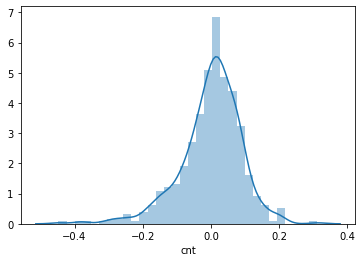

In [42]:
y_train_pred = lm_4.predict()
##Observing the distribution of training error terms
sns.distplot(y_train-y_train_pred)

### Observations: 
- The errors are normally distributed
- The errors are centered zero
- This meets our assumptions

## Step 4 : Evaluation of the model

We will now evaluate the model on test train set and plot the behaviour

In [43]:
y_train_pred = lm_4.predict()

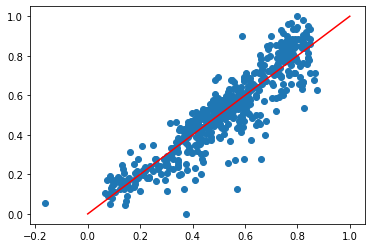

In [44]:
plt.scatter(y_train_pred,y_train)
## reference line passing through origin
plt.plot([0,1],[0,1],color='red')

## Predicting on test data

### Evaluation on test data set

We will observe the behavior on the test data

In [45]:
## Adding constant in test data set
X_test = sm.add_constant(X_test)


### Making the shape of the test dataset same as train data set
###Dropping the columns that are not present in the train data set
X_test_new = X_test[X_train_sm.columns]


In [46]:
Y_test_pred = lm_9.predict(X_test_new)

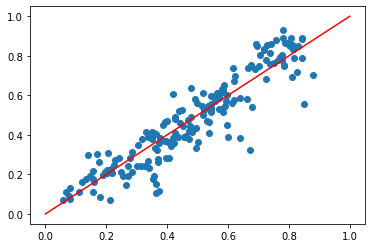

In [47]:
plt.scatter(Y_test_pred,y_test)
plt.plot([0,1],[0,1],color='red')

### Observations:

The behavior of the model seems to be linear on the test set as well. 

### Let us compare the r2 score on the test set

In [48]:
r2_score(y_test, Y_test_pred)

0.8545859878274278

## Observations:

1. The r2 score is around 0.85 on the test set
2. Our model seem to respond well on the test set 

### Let us see the eqation of the model

#### The below code prints the model equation

In [49]:
vars = lm_4.params
index = lm_4.params.index
eqn = ''
i = 0
for param in vars:
    
    eqn += ' + '+ index[i] + '*('+str(param) + ')  '
    
    i+=1
print("The equation of the model is: \n")    
print(eqn)

The equation of the model is: 

 + const*(0.33954454153690317)   + yr*(0.23226286656576417)   + temp*(0.43462682341522885)   + hum*(-0.16900589325028204)   + windspeed*(-0.19343739730838172)   + Mon*(-0.017294242647451545)   + Dec*(-0.028861039175132497)   + Jan*(-0.028088189781359543)   + Jul*(-0.040361873664421136)   + March*(0.053499481044524344)   + May*(0.03545004338164878)   + Nov*(-0.029006309028477617)   + Oct*(0.03880858071612983)   + Sep*(0.08117586745677953)   + Spring*(-0.10033945540565725)   + Summer*(0.019183532605429862)   + Winter*(0.06172800307040071)   + Light Rain*(-0.2060981979673413)   + Mist*(-0.03088216679265873)  


In [50]:
## The value of the const is 1